<a href="https://colab.research.google.com/github/d1p013/testing/blob/master/Simple_Search_Engine_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI6122 Assignment 1 - Section 3.3


## Prerequisites

You will need PyTerrier installed. PyTerrier also needs Java to be installed, and will find most installations.

In [53]:
!pip install python-terrier
#!pip install --upgrade git+https://github.com/terrier-org/pyterrier.git#egg=python-terrier

## Init 

You must run `pt.init()` before other pyterrier functions and classes

Optional Arguments:    
 - `version` - terrier IR version e.g. "5.2"    
 - `mem` - megabytes allocated to java e.g. "4096"      
 - `packages` - external java packages for Terrier to load e.g. ["org.terrier:terrier.prf"]
 - `logging` - logging level for Terrier. Defaults to "WARN", use "INFO" or "DEBUG" for more output.

NB: PyTerrier needs Java 11 installed. If it cannot find your Java installation, you can set the `JAVA_HOME` environment variable.

In [54]:
import pyterrier as pt
if not pt.started():
  pt.init()

 ## Importing dataset from Google Drive

Using built-in function of Google Colab, we can easily import the dataset which has been uploaded onto Google Drive beforehand

need a Google account to download the data

In [55]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID which is residing on Google Drive
#
file_id = '1aVXMJ_luTXISxMwP5_Bt2xE0ObXqEsQ2' #"Dataset_B1to8"

downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('Dataset_B1to8.csv')

## Loading dataset (csv) into Pandas dataframe

PyTerrier makes it easy to index standard Python data structures, particularly [Pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

importing dataset, which is scale down version of the original `review.json` file as the original file is too large to load into Google Colab memory


In [56]:
## load data into df
import pandas as pd
#df = pd.read_csv("AI6122_Dataset_B1.csv", dtype = str)
df = pd.read_csv("Dataset_B1to8.csv", dtype = str)

try :
  del docno 
except:
  pass

docno =[]
for idx in range(1,len(df)+1):
  docno.append("d" + str(idx))

df["docno"] = docno


## Time taken for indexing

Tracking the time to complete indexing for each 10% incremental of documents. The index folder is cleared before each indexing and time and is taken before and after indexing, the difference being the time taken to index


In [57]:
import time

Tcollect = []
for idx in range(1,11):
  #print(idx)
  df_resize = df.iloc[:int(len(df)/(10/idx)),:]
  !rm -rf ./pd_index
  pd_indexer = pt.DFIndexer("./pd_index", overwrite=True, verbose=True)
  Tstart = time.perf_counter()
  indexref = pd_indexer.index(df_resize["text"], df_resize)
  Tend = time.perf_counter()
  print(str(10*idx)+f"% df search completed in {Tend - Tstart:0.4f} seconds")
  Tcollect.append(Tend - Tstart)



  0%|          | 0/692 [00:00<?, ?documents/s]

10% df search completed in 1.9131 seconds


  0%|          | 0/1385 [00:00<?, ?documents/s]

20% df search completed in 2.5850 seconds


  0%|          | 0/2078 [00:00<?, ?documents/s]

30% df search completed in 3.3994 seconds


  0%|          | 0/2771 [00:00<?, ?documents/s]

40% df search completed in 4.3184 seconds


  0%|          | 0/3464 [00:00<?, ?documents/s]

50% df search completed in 5.1489 seconds


  0%|          | 0/4156 [00:00<?, ?documents/s]

60% df search completed in 6.3646 seconds


  0%|          | 0/4849 [00:00<?, ?documents/s]

70% df search completed in 6.8048 seconds


  0%|          | 0/5542 [00:00<?, ?documents/s]

80% df search completed in 7.4431 seconds


  0%|          | 0/6235 [00:00<?, ?documents/s]

90% df search completed in 8.1100 seconds


  0%|          | 0/6928 [00:00<?, ?documents/s]

100% df search completed in 9.0928 seconds


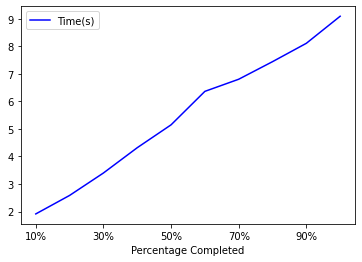

In [58]:
import matplotlib.pyplot as plt

plotdf = pd.DataFrame({
    'Percentage Completed':['10%', '20%', '30%', '40%', '50%', 
                            '60%', '70%', '80%', '90%', '100%'],
    'Time(s)':Tcollect
    })

# a scatter plot comparing num_children and num_pets
plotdf.plot(kind='line',x='Percentage Completed',y='Time(s)',color='blue')
plt.show()


## Indexing a Pandas dataframe

We can use a `pt.DFIndexer()` object to do indexing for Pandas dataframe

In [59]:
#import pandas as pd
!rm -rf ./pd_index
pd_indexer = pt.DFIndexer("./pd_index", overwrite=True, verbose=True, blocks=True)

# optionally modify properties
pd_indexer.setProperty("tokeniser" , "EnglishTokeniser")
pd_indexer.setProperty("termpipelines", "Stopwords,PorterStemmer")
# no stemming or stopwords
#pd_indexer.setProperty("termpipelines", "")

Then there are a number of options to index the dataframe:    
The first argument should always a pandas.Series object of Strings, which specifies the body of each document.    
Any arguments after that are for specifying metadata.

We can view more useful information from the indexed objects using a indexref.getCollectionsStatistics()

In [60]:
import time

# Add metadata fields as Pandas.Series objects, with the name of the Series object becoming the name of the meta field.
Tstart = time.perf_counter()
# Add the entire dataframe as metadata
indexref = pd_indexer.index(df["text"], df)
Tend = time.perf_counter()
print(f"search completed in {Tend - Tstart:0.4f} seconds")
indexinfo = pt.IndexFactory.of(indexref)
print(indexinfo.getCollectionStatistics().toString()) 

  0%|          | 0/6928 [00:00<?, ?documents/s]

search completed in 9.9974 seconds
Number of documents: 6928
Number of terms: 12049
Number of postings: 323743
Number of fields: 0
Number of tokens: 388543
Field names: []
Positions:   true



In the above example, the indexed collection had 6928 documents, which contained 388543-word occurrences. Out of which 12049 were identified as unique words. The total postings in the inverted index are 323743. 

The whole datafame is being index, with the `"text"` field being searchable while the remaining (e.g. `"review_id"`, `"user_id"`, `"business_id"`, `"stars"`, `"date"`, `"useful"`, `"funny"`, `"cool"`, `"text"`) as metadata which can be displayed when called upon.

pyTerrier perform standard stopwords removal and applies Porter's stemmer by default, and it is applicable in this notebook as well.
EnglishTokeniser is the default tokeniser and case-folding to lower case is applied during Tokenization

## Retrieval

Retrieval takes place using the `BatchRetrieve` object, by invoking `transform()` method for one or more queries. For a quick test, you can give just pass your query to `transform()`. 

BatchRetrieve will return the results as a Pandas dataframe.


## Simple Search Engine

Prompting user input for search string
Prompting user input for the Top N results to return
Display the time taken to complete the search
Display the search results

# Definition for Simple Search Engine

In [61]:
def SimpleSearch():
  import time
  import pandas as pd
  pd.reset_option('^display.', silent=True)
  #pd.set_option('display.max_rows', None)
  pd.set_option('display.max_columns', None)
  #pd.set_option('display.width', None)
  #pd.set_option('display.max_colwidth', -1)

  search_str = input("Please enter your search string: ")
  #print("Search string: ", search_str)
  TopN = input("Please enter number results to display: ")
  #print("Top N results: ", TopN)
  Tstart = time.perf_counter()
  topics = pd.DataFrame([["q1", "#1("+search_str+")"]],columns=['qid','query'])
  results = pt.BatchRetrieve(indexref, wmodel="BM25", properties={"termpipelines" : "Stopwords,PorterStemmer"}, metadata=["text"], num_results=int(TopN)).transform(topics)
  Tend = time.perf_counter()
  print(f"search completed in {Tend - Tstart:0.4f} seconds")

  if len(results) == 0:
    print("no result found!")
  #else:
    #print("len: ", len(results))
    #print(results)

  return results

# Search #1
Keywords "restaurant"

In [62]:
SimpleSearch()

Please enter your search string: restaurant
Please enter number results to display: 5
search completed in 0.0457 seconds


,qid,docid,text,rank,score,query
0,q1,338,We visited the restaurant at 3:30. We were a l...,0,12.022172,#1(restaurant)
1,q1,5405,A quality restaurant with excellent food. The ...,1,11.865114,#1(restaurant)
2,q1,4224,Another amazing dining experience with a Colum...,2,11.762669,#1(restaurant)
3,q1,664,We came in for the SEC game and stumbled on th...,3,11.694654,#1(restaurant)
4,q1,4172,I think that every restaurant in the country s...,4,11.694654,#1(restaurant)


# Search #2
Keywords "honda"

In [63]:
SimpleSearch()

Please enter your search string: honda
Please enter number results to display: 5
search completed in 0.0359 seconds
no result found!


,docid,text,rank,score,qid,query


#Search #3
Key phrase "homemade meatballs"
docid 37 & 445 will provide test case for this search phrase

In [64]:
SimpleSearch()

Please enter your search string: homemade meatballs
Please enter number results to display: 5
search completed in 0.0363 seconds


,qid,docid,text,rank,score,query
0,q1,442,Our party of 5 waited about an hour and a half...,0,4.430179,#1(homemade meatballs)


#Search #4
Key phrase "homemade pasta"
docid 37 & 445 will provide test case for this search phrase

In [65]:
SimpleSearch()

Please enter your search string: homemade pasta
Please enter number results to display: 5
search completed in 0.0303 seconds


,qid,docid,text,rank,score,query
0,q1,37,Amazing! Ate here while in town for a conferen...,0,9.081460,#1(homemade pasta)
1,q1,4051,I am writing this review in retrospect. We re...,1,6.395560,#1(homemade pasta)
2,q1,4093,We have visited L'Andana in several occasions ...,2,6.263246,#1(homemade pasta)
3,q1,4314,"If you're in the area, it is HANDS-DOWN the be...",3,6.263246,#1(homemade pasta)
4,q1,4077,Love this restaurant! Easy to get to off of 12...,4,6.136296,#1(homemade pasta)


@inproceedings{pyterrier2020ictir,

    author = {Craig Macdonald and Nicola Tonellotto},
    title = {Declarative Experimentation inInformation Retrieval using PyTerrier},
    booktitle = {Proceedings of ICTIR 2020},
    year = {2020}
}

